## 修正的批注
1. （重要）原算法中只对n_n个粒子中选定的粒子运动跑Langevin运动。虽然单步来看是对的，但是我们的warm start 要求从上一步计算得到的$(\Theta_{t,S})$开始跑而不是从，经过fictitious play birth-death步骤的，$m_t$作为初始值开始跑的。

2.  修正了一些数组运算，尽可能讲等号换成np.copy避免深复制(deep copy)

3. （重要）原算法中前后的洗漱C上的truncate不一致，现在已将他们全部对齐。在更新Langevin算法的时候，C不再被截断（怀疑是bug）
4.  把particlawise的langevin算法向量化了
5.  设置了annealed的regularized parameter？要不要，要可以让收敛更好更稳定，不要则是原生问题的优化过程，但是收敛极小不一定对
6.  （非常重要）所谓的regurlized para就是 sigma ^2 /2, 删掉了没用的sigma，修正了正确的Langevin算法的噪声项系数，原来是二次weight decay前是lambda 后面噪声强度还是lambda

In [20]:
import numpy as np
# import numba as nb
import matplotlib.pyplot as plt
import time
import warnings
# warnings.filterwarnings('ignore')

import pickle 

In [21]:
# Fix global variables全局参数
n_z     = 1   # number of features
n_n     = 1000  # number of initial neurons
n_per_dim = 101
n       = n_per_dim * n_z
alpha   = 1
# alpha   = 1.0 / n_n
lambda_reg = 0.0005
c_cutoff = 5
m_star_error = 0.1 # 用在每次更新参数时的随机变量 (1+N(0,1/10^2))* theta，已弃置

In [22]:
def reLU(x): # 注意：Relu函数被截断
    return np.minimum(np.maximum(0,x),5)

def dreLU(x):
    return np.where((x > 0) & (x < 5), 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def loss(x, y):
    return (x - y)**2 / 2

def loss_vec(xs: np.ndarray((n)), ys: np.ndarray((n))):
    return (xs - ys)**2 / 2

# 截断函数
def Tc(x):
    return np.minimum(np.maximum(-c_cutoff,x),c_cutoff)

def dTc(x):
    return np.where((x > -c_cutoff) & (x < c_cutoff), 1, 0)

### 神经网络的表示
$$y = \frac{1}{n_n} \sum_{i=1}^{n_n}   l(C_i) \varphi\Big(\sum_{j=1}^{n_z} z_j W_{ij} + b_i\Big)$$
where $l(\cdot)$ is a truncate function for the weight $C_i$.

#### 逐向量形式下的predict

In [23]:
# def predict(
#     C: np.ndarray((n_n)),
#     W: np.ndarray((n_n, n_z)), 
#     b: np.ndarray((n_n)), 
#     z: np.ndarray((n_z)),
#     weights: np.ndarray((n_n)),
#     activ_func: "function" = reLU
#     ):
#     '''
#     Implement
#     y = sum_{i=1}^{n_n} weights_i * C_i * phi(sum_{j=1}^{n_z} z_j W_{ij} + b_i)

#     Here we assume activ_func is "vectorized", i.e. allowing passing
#     array_like object as argument, and computes component-wise. 
#     '''
#     activ_func_arg = np.matmul(W, z) + b # of shape (n_n)
#     return weights * C * activ_func(activ_func_arg).sum()

#### Vector形式下的predict

In [24]:
def predict_vec(
    C: np.ndarray((n_n)),
    W: np.ndarray((n_n, n_z)), 
    b: np.ndarray((n_n)), 
    weights: np.ndarray((n_n)),
    zs: np.ndarray((n_z, n)),
    activ_func: "function" = reLU
    ):
    '''
    Implement vectorized version of predict(). 
    '''
    activ_func_arg = np.tensordot(W, zs, axes=(1,0)) + np.expand_dims(b, axis=1) # of shape (n_n,n)
    return np.sum(np.expand_dims(weights, axis=1) * np.expand_dims(Tc(C), axis=1) * activ_func(activ_func_arg),axis=0).squeeze()

def error(Cs, Ws, bs, weights, zs, ys, activ_func=reLU):
    predicts = predict_vec(Cs, Ws, bs, weights, zs, activ_func)
    return loss(predicts, ys).mean()


####  初始化各种三大参数C, W, b和 weights，这里weights都被固定成了1/n_n

In [25]:
def init_params(mean=0, scale=1):
    '''
    Initialize W and b. 
    '''
    C = scale * rng.standard_normal(size=(n_n)) + mean
    W = scale * rng.standard_normal(size=(n_n,n_z)) + mean
    b = scale * rng.standard_normal(size=(n_n)) + mean
    weights = np.full((n_n), 1.0/n_n)
    return C, W, b, weights

def init_FP_params(mean=0, scale=1):  # 事实上没有用 W_star 初始为 W
    '''
    Initialize W and b for the Fokker-Planck dynamics.
    '''
    c_0 = scale * rng.standard_normal(n_n) + mean             
    w_0 = scale * rng.standard_normal(size=(n_n, n_z)) + mean 
    b_0 = scale * rng.standard_normal(n_n) + mean            
    return c_0, w_0, b_0

#### Innerloop Langevin algotithm (Fokker Planck过程)  更新过程依照论文
$$\left\{\begin{array}{l}d \beta_s=\frac{1}{K} \sum_{k=1}^{K}\left(y_k-\mathbb{E}^m\big[h(\beta)\cdot\varphi\left(\alpha z_k+\gamma\right)\big]\right)h'(\beta_s)\varphi\left(\alpha_s z_k+\gamma_s\right) d s-\frac{\sigma^2}{2} \beta_s d s+\sigma d W_s^\beta \\ 
d \alpha_s=\frac{1}{K} \sum_{k=1}^{K}\left(y_k-\mathbb{E}^m\big[h(\beta)\cdot\varphi\left(\alpha z_k+\gamma\right)\big]\right) h(\beta_s) z_k \varphi'\left(\alpha_s z_k+\gamma_s\right) d s-\frac{\sigma^2}{2}  \alpha_s d s+\sigma d W_s^\alpha \\ 
d \gamma_s=\frac{1}{K} \sum_{k=1}^{K}\left(y_k-\mathbb{E}^m\big[h(\beta)\cdot\varphi\left(\alpha z_k+\gamma\right)\big]\right) h(\beta_s) \varphi'\left(\alpha_s z_k+\gamma_s\right) d s-\frac{\sigma^2}{2}  \gamma_s d s+\sigma d W_s^\gamma\end{array}\right.$$
for $s=1,2,...,n_n$. In the experiments, we set $\varphi(x) = \min \big(\max(0,x), h\big)$, where $h$ is to be determined. $\alpha_s$ is the s-th row of $\alpha$, as the order of numpy array.

In [26]:
def FP_dynamics(
    C: np.ndarray((n_n)),
    C_star: np.ndarray((n_n)),
    W: np.ndarray((n_n, n_z)),
    W_star: np.ndarray((n_n, n_z)),
    b: np.ndarray((n_n)),
    b_star: np.ndarray((n_n)),
    weights: np.ndarray((n_n)),
    
    zs: np.ndarray((n_z, n)),
    ys: np.ndarray((n)),
    
    activ_func: "function" = reLU,
    d_activ_func: "function" = dreLU,
    
    horizon_s: float = 10,
    delta_s: float = 0.1,
    alpha : float = 0.1,
    lambda_reg: float = 0.001,
    firststep: bool = False,
    ):
    
    '''
    Calculate the Fokker-Planck evolution
    '''
    num_epochs = int(np.floor(horizon_s / delta_s))
    
    if firststep == True:
        num_epochs = 20 * int(np.floor(horizon_s / delta_s))
        
    predicts = predict_vec(C, W, b, weights, zs, activ_func) # of shape (n)

    c_curr = C_star.copy()
    w_curr = W_star.copy()
    b_curr = b_star.copy()

    for epoch_s in range(1, num_epochs):
        # Calculate the derivate manually (maybe to be changed)
        
        activ_func_arg = np.tensordot(w_curr, zs, axes=(1,0)) + np.expand_dims(b_curr, axis=1) # of shape (n_n, n)
        
        activ_func_output   = activ_func(activ_func_arg)
        d_activ_func_output = d_activ_func(activ_func_arg) # of shape (n_n,n)

        c_drift = - ((predicts - ys) * activ_func_output).mean(axis=1) * dTc(c_curr) - lambda_reg * c_curr
        b_drift = - ((predicts - ys) * d_activ_func_output).mean(axis=1) * Tc(c_curr) - lambda_reg * b_curr
        
        # Probably suboptimal
        w_drift = np.ndarray((n_n,n_z))
        
        for j in range(n_z):
            w_drift[:,j] = (d_activ_func_output * (ys - predicts) * zs[j]).mean(axis=1) * Tc(c_curr)  - lambda_reg * w_curr[j]

        # Increment
        c_curr += c_drift * delta_s + (2*lambda_reg)**(1/2) * np.sqrt(delta_s) * rng.standard_normal(n_n)
        # c_curr = TC(c_curr) 
        w_curr += w_drift * delta_s + (2*lambda_reg)**(1/2) * np.sqrt(delta_s) * rng.standard_normal(size=(n_n,n_z))    
        b_curr += b_drift * delta_s + (2*lambda_reg)**(1/2) * np.sqrt(delta_s) * rng.standard_normal(n_n)                     
    return c_curr, w_curr, b_curr


#### 每次随机杀死其中n_change个神经元

In [27]:
def get_mstar_new(
    C: np.ndarray((n_n)),
    C_star: np.ndarray((n_n)),
    W: np.ndarray((n_n, n_z)), 
    W_star: np.ndarray((n_n, n_z)), 
    b: np.ndarray((n_n)),
    b_star: np.ndarray((n_n)),
    weights: np.ndarray((n_n)),
    
    zs: np.ndarray((n_z, n)),
    ys: np.ndarray((n)),
    activ_func: "function" = reLU,
    d_activ_func: "function" = dreLU,
    horizon_s: float = 10,
    delta_s: float = 1.,
    alpha: float = 0.1, # 实际的学习率，往往是时间步长跟设置的学习率之积，不能超过1
    lambda_reg: float = 0.001, # 正则化系数
    firststep: bool = False,
    ):
    '''
    Use old mstar data to get new mstar
    '''
    n_n = len(weights)
    n_change = int(n_n*alpha) # number of changing neurons
    index = np.random.choice(n_n, size=n_change,replace=False)
    
    # update with vectorized FP_dynamics (birth-death)
    C_stat, W_star, b_star = FP_dynamics(
            C, C_star, W, W_star,b, b_star, weights, zs, ys, 
            activ_func=activ_func, d_activ_func=d_activ_func, 
            horizon_s=horizon_s, delta_s=delta_s, lambda_reg=lambda_reg, firststep=firststep)
    
    for i in index:
        C[i], W[i], b[i] = C_star[i], W_star[i], b_star[i]
        
    return C, C_star, W, W_star, b, b_star, weights

In [28]:
# target_func = lambda x_1, x_2: np.sin(2 * np.pi * x_1) + np.cos(2 * np.pi * x_2)
target_func = lambda x_1: np.sin(2 * np.pi * x_1)
# target_func = lambda x_1: 2*x_1**3-10*x_1**2+10*x_1-1

# generate samples
def gen_samples(func, interval_start, interval_end, size=n_per_dim):
    '''
    Generate samples from vectorized function func()
    '''
    zs = np.linspace(interval_start, interval_end, size)
    ys = func(zs)
    return np.array([zs]), ys

def gen_2d_samples(func, interval_start, interval_end, size=n_per_dim):
    coordinate_list = np.linspace(interval_start, interval_end, size)
    z1s, z2s = np.meshgrid(coordinate_list, coordinate_list)
    z1s = z1s.flatten()
    z2s = z2s.flatten()
    zs = np.array([z1s, z2s])
    ys = func(z1s, z2s)
    return zs, ys

def shape_to_plot(a):
    return a.reshape((n_per_dim,n_per_dim))

zs, ys = gen_samples(target_func, 0, 1)

zs_valid, ys_valid = gen_samples(target_func, 0, 1, size=1001)

In [33]:
# @nb.jit()
def mainprocess(C, W, b, weights):
    C_star, W_star, b_star, weights_star = C.copy(), W.copy(), b.copy(), weights  # 表示 \hat m 的参数表达， 下同
    horizon_t = 120.0 # 时间长度
    delta_t = 0.2 # 时间间隔
    num_epochs = int(np.floor(horizon_t / delta_t)) # 迭代次数

    func_fig, func_ax = plt.subplots() # 函数图
    err_fig, err_ax = plt.subplots() # 误差图

    err_train = []
    err_valid = []
    predicts_list = []
    
    rng = np.random.default_rng() # 释放固定随机数
    
    # Train
    start = time.perf_counter()
    for epoch_t in range(num_epochs + 1):
        
        err_train.append(error(C, W, b, weights, zs, ys, activ_func=reLU))
        err_valid.append(error(C, W, b, weights, zs_valid, ys_valid, activ_func=reLU))

        if (epoch_t % 40 == 0 or epoch_t==0 or epoch_t==1):
            print("EPOCH", epoch_t)
            print(err_train[epoch_t])
            print(err_valid[epoch_t])

            if (epoch_t % 40 == 0 and epoch_t >0): #去掉了0的情况
                predicts = predict_vec(C, W, b, weights, zs, activ_func=reLU)

                func_ax.plot(zs[0], predicts, label="Epoch " + str(epoch_t))
        
        if epoch_t < 1:
            firststep = True
        else:
            firststep = False
            
        C, C_star, W, W_star, b, b_star, weights = get_mstar_new(
            C, C_star, W, W_star, b, b_star, weights, 
            zs, ys,horizon_s=5.0,
            delta_s=0.1,alpha=alpha * delta_t,lambda_reg = 0.0005,
            activ_func=reLU, d_activ_func=dreLU,firststep=firststep)
        
        
        predicts_list.append(predict_vec(C, W, b, weights, zs, activ_func=reLU)) # 绘图用
        
    end = time.perf_counter()
    print("time consuming : %.2fs"%(end-start))
    
    func_ax.plot(zs_valid[0], ys_valid, label="Target")
    func_ax.set_xlabel("Time")
    func_ax.set_ylabel("Label")
    func_ax.set_title("Function with different Epoch")
    func_ax.legend()
    func_ax.set_xlim(left=0,right=1)
    func_ax.set_ylim(bottom=-2,top=2)
    
    
    err_ax.semilogy(range(num_epochs + 1), err_valid)
    err_ax.set_xlabel("Train Epochs")
    err_ax.set_ylabel("Validation Error")
    err_ax.set_title("Error in different times Epochs")

    '''
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    zs_plot    = np.ndarray((n_z, n_per_dim, n_per_dim))
    zs_plot[0] = shape_to_plot(zs[0])
    #zs_plot[1] = shape_to_plot(zs[1])
    ys_plot    = shape_to_plot(ys)
    predicts_plot = shape_to_plot(predicts)

    ax.contour3D(zs_plot[0], zs_plot[1], ys_plot, 50, cmap='binary')
    ax.contour3D(zs_plot[0], zs_plot[1], predicts_plot, 50, cmap='binary')
    ax.set_xlabel('z1')
    ax.set_ylabel('z2')
    ax.set_zlabel('y');
    '''
    
    plt.show()
    return C, W, b, weights, err_train, err_valid, predicts_list

EPOCH 0
1.0143132006519566
1.0177909260110456
EPOCH 1
0.46227673701874494
0.46553918782816367
EPOCH 40
0.05513627655278235
0.055500171347205036
EPOCH 80
0.04329479439146865
0.043598213096883415
EPOCH 120
0.03143687531426366
0.031659063240755764
EPOCH 160
0.018164334958026624
0.018265904262939833
EPOCH 200
0.011780699254235943
0.01183565566132082
EPOCH 240
0.006774151586102819
0.006807408429133242
EPOCH 280
0.0026647034062655074
0.0026580251189883713
EPOCH 320
0.0010261004500703326
0.001017793612324237
EPOCH 360
0.00043689901044170976
0.0004246114121392921
EPOCH 400
0.00019823136761934308
0.00018043458718077076
EPOCH 440
0.00020232901822867227
0.0001812172717463896
EPOCH 480
0.000193275662945827
0.00017022587339199168
EPOCH 520
0.00021180882430963345
0.00018433280216044787
EPOCH 560
0.00017875975351466927
0.00016067069725974174
EPOCH 600
0.00017645490436615926
0.00015897528922828184
time consuming : 63.02s


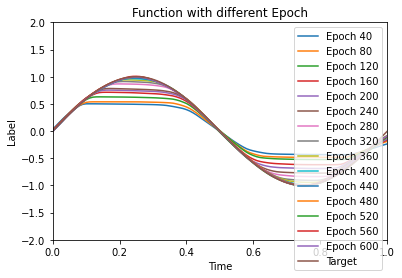

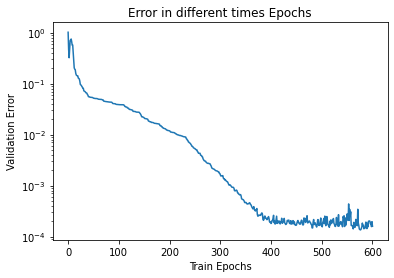

In [34]:
# RNG 随机生成器
rng = np.random.default_rng(0)
# random_state = np.random.get_state()
# print(rng.random())

C, W, b, weights = init_params(mean=0,scale=15.0) #初始要求N(0,15^2)

C_fin, W_fin, b_fin, weights_fin, err_train, err_valid, predicts_list = mainprocess(C, W, b, weights)

#### 序列化/读取

In [35]:
with open('data_1.txt','wb') as f:
    pickle.dump({'err_train':err_train,'err_valid':err_valid,'predicts_list':predicts_list},f)  

In [36]:
with open('data_1.txt','rb') as f:
    data_dict = pickle.load(f)  
err_train,err_valid,predicts_list = data_dict['err_train'],data_dict['err_valid'],data_dict['predicts_list']

#### 重现可视化

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn
from sklearn import linear_model

In [38]:
n_per_dim = 101
target_func = lambda x_1: np.sin(2 * np.pi * x_1)
def gen_samples(func, interval_start, interval_end, size=n_per_dim):
    '''
    Generate samples from vectorized function func()
    '''
    zs = np.linspace(interval_start, interval_end, size)
    ys = func(zs)
    return np.array([zs]), ys
zs, ys = gen_samples(target_func, 0, 1)
zs_valid, ys_valid = gen_samples(target_func, 0, 1, size=1001)

In [39]:
cmap = seaborn.color_palette("OrRd")
cmap[0]

(0.9955709342560554, 0.8996539792387543, 0.7629988465974625)

<IPython.core.display.Javascript object>


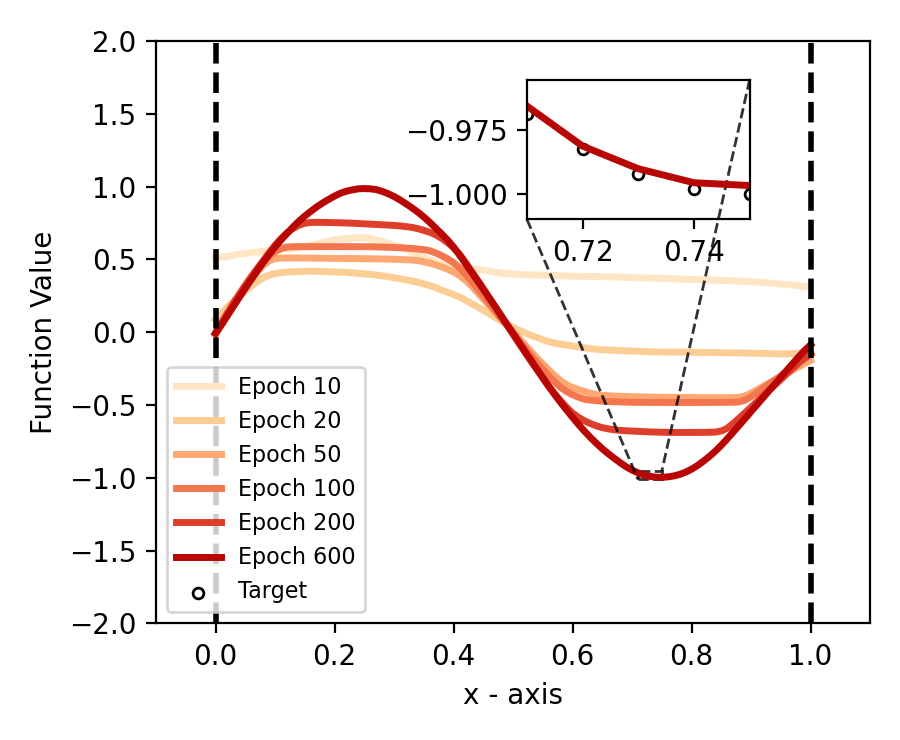

<ipython-input-71-b86d5810ff6d>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [71]:
%matplotlib notebook
with plt.style.context('seaborn-deep'):
    func_fig, func_ax = plt.subplots(figsize=(4.5,3.7)) # 函数图
    cmap = seaborn.color_palette("OrRd")
    
    for idx, time in enumerate([10,20,50,100,200,600]):
        func_ax.plot(zs[0], predicts_list[time], label="Epoch " + str(time),c=cmap[idx],linewidth=2.5)

    # func_ax.plot(zs_valid[0], ys_valid, '-.',label="Target",linewidth=2,c='k',alpha=0.2)    

    func_ax.plot(np.zeros(10), np.linspace(-2,2,10), '--', c='k', linewidth=2)
    func_ax.plot(np.ones(10), np.linspace(-2,2,10), '--', c='k', linewidth=2)
    func_ax.scatter(5*np.ones(10), np.linspace(-2,2,10),marker='o',label="Target",s=15,c='w',edgecolor='k') 

    func_ax.set_xlabel("x - axis")
    func_ax.set_ylabel("Function Value")
    # func_ax.set_title("Approximated Function with different Epoch")
    func_ax.legend(fontsize=8)
    func_ax.set_xlim(left=-0.1,right=1.1)
    func_ax.set_ylim(bottom=-2,top=2)

    axins = inset_axes(func_ax, width="40%", height="30%",loc='lower left',
                       bbox_to_anchor=(0.5, 0.67, 0.78, 0.8),
                       bbox_transform=func_ax.transAxes)
    axins.set_xlim(0.71, 0.75)
    axins.set_ylim(-1.01, -0.955)

    for time in [10,20,50,100,200,600]:
        axins.plot(zs[0], predicts_list[time], label="Epoch " + str(time),c=cmap[idx],linewidth=2.5)

    axins.scatter(zs[0], ys,marker='o',label="Target",s=15,c='w',edgecolor='k') 
#     axins.plot(zs_valid[0], ys_valid, '-',label="Target",linewidth=1,alpha=0.5) 

    # axins.set_xticks([])
    # axins.set_yticks([])

    mark_inset(func_ax, axins,loc1=3, loc2=1, fc="none", ec='k', lw=1,linestyle='--',alpha=0.8)
    plt.tight_layout()
    plt.savefig('functions.png',dpi=600,transparent=False, bbox_inches = 'tight')
    plt.show()

<IPython.core.display.Javascript object>


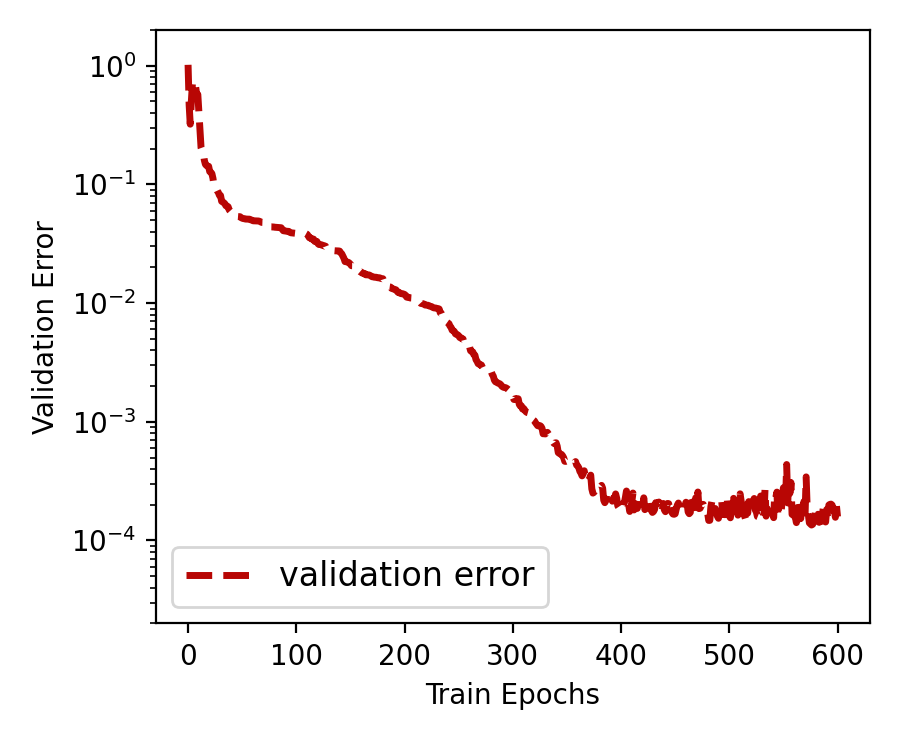

In [72]:
err_fig, err_ax = plt.subplots(figsize=(4.5,3.7)) # 误差图

log_ks = np.log(np.arange(20,len(err_valid)))
log_errs = np.log(err_valid[20:])

model = linear_model.LinearRegression()
model.fit(log_ks.reshape(-1, 1),log_errs)

# err_ax.plot(np.arange(20,len(err_valid)), np.exp(model.intercept_ + model.coef_[0] * log_ks) ,'--', c='k',linewidth=2.5, label='Fitted')

err_ax.semilogy(np.arange(len(err_valid)), err_valid,'--',linewidth=2.5,c=cmap[5],label='validation error')
# err_ax.loglog(np.arange(len(err_train)), err_valid,label='train error')

# err_ax.plot(np.linspace(0,600,2),np.ones(2)*1e-4,'--',c='k',label='1e-4')
err_ax.set_xlabel("Train Epochs")
err_ax.set_ylabel("Validation Error")
# err_ax.set_title("Error in different times Epochs")
err_ax.legend(loc='lower left',fontsize=12)
err_ax.set_ylim((2e-5,2))

plt.tight_layout()
plt.savefig('errors2.png',dpi=600,transparent=False,bbox_inches = 'tight')
plt.show()

In [34]:
# def Separation(C,W,b,weights,alpha):
#     n_n = len(C)
#     n_change = int(n_n*alpha) # number of changing neurons
#     index = np.random.choice(n_n, size=n_change,replace=False)
#     C_c, W_c, b_c = C[index], W[index], b[index]
#     C = np.delete(C,index,axis=0)
#     W = np.delete(W,index,axis=0)
#     b = np.delete(b,index,axis=0)
#     return C,W,b,C_c, W_c, b_c, weights